## TPR-FPR

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import json
import os
import re
from collections import Counter

In [4]:
def extract_yes_no(answer):
    """Extract 'Yes' or 'No' from a response."""
    match = re.search(r'\b(Yes|No)\b', answer, re.IGNORECASE)
    return match.group(1).capitalize() if match else "Unknown"

def find_tpr_at_fpr(fpr, tpr, target_fpr):
    """Find the TPR at a specific FPR value using np.interp."""
    return np.interp(target_fpr, fpr, tpr)

def process_file(file_path):
    """Process the JSON file to count exact appearance ratios."""
    with open(file_path, 'r') as f:
        data = json.load(f)

    exact_counts = Counter()
    total_retrieved = 0
    total_doc_possibilities = 0
    for target_doc, item in data.items():
        if item.get("mem") == "yes":
            retrieved_doc_lists = item["retrieved_doc_ids"]
            count_in_retrieved = sum(1 for docs in retrieved_doc_lists if target_doc in docs)
            total_questions = len(retrieved_doc_lists)
            exact_counts[f"{count_in_retrieved}/{total_questions}"] += 1

            total_retrieved += count_in_retrieved
            total_doc_possibilities += total_questions

    return exact_counts, total_retrieved / total_doc_possibilities

In [5]:
def get_mia_scores(data):
    all_acc = []
    for doc_id, doc_data in data.items():
        correct_answers = doc_data['answers']
        llm_responses = doc_data['llm_responses']
        total_questions = len(correct_answers)
        correct_count = 0

        # Compare LLM responses with correct answers
        for i in range(total_questions):
            # Extract 'Yes' or 'No' from both the LLM response and the correct answer
            correct_answer = extract_yes_no(correct_answers[i])
            llm_answer = extract_yes_no(llm_responses[i])

            if correct_answer == llm_answer:
                correct_count += 1

        # Calculate accuracy for the document
        accuracy = correct_count / total_questions * 100
        all_acc.append(accuracy)
    return all_acc


def get_s2_scores(data):
    all_acc = []
    for doc_id, doc_data in data.items():
        all_acc.append(doc_data['bleu_score'])
    return all_acc


def get_mba_scores(data):
    all_acc = []
    for doc_id, doc_data in data.items():
        all_acc.append(doc_data['accuracy'])
    return all_acc


def get_dq_scores(data):
    expected_answers, predicted_answers = [], []

    for doc_id, doc_data in data.items():
        expected_answer = 1 if doc_data["mem"].lower() == "yes" else 0
        llm_response = extract_yes_no(doc_data["llm_responses"][0])
        if llm_response == "Invalid":
            continue

        predicted_answer = 1 if llm_response == "Yes" else 0
        expected_answers.append(expected_answer)
        predicted_answers.append(predicted_answer)

    # Calculate metrics
    accuracy = accuracy_score(expected_answers, predicted_answers) * 100
    precision = precision_score(expected_answers, predicted_answers, zero_division=0)
    recall = recall_score(expected_answers, predicted_answers, zero_division=0)
    f1 = f1_score(expected_answers, predicted_answers, zero_division=0)

    # ROC point
    fpr = 1 - precision  # False Positive Rate
    tpr = recall  # True Positive Rate

    return accuracy, precision, recall, f1, fpr, tpr

In [6]:
output_dir = 'results/target_docs'
ATTACK = 'direct_query'
GENERATOR = 'command_r' #'gemma2_2b'
RETRIEVER = 'gte'
DATASET = 'trec-covid'
log_scale = False
FPR_FOR_AUC = 0.1 # Threshold that yields <= FPR to compute accuracy

Accuracy: 52.35, Precision: 0.5121, Recall: 0.9980, F1: 0.6768, FPR: 0.4879, TPR: 0.9980


/tmp/ipykernel_2287856/606390097.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right", fontsize=12)


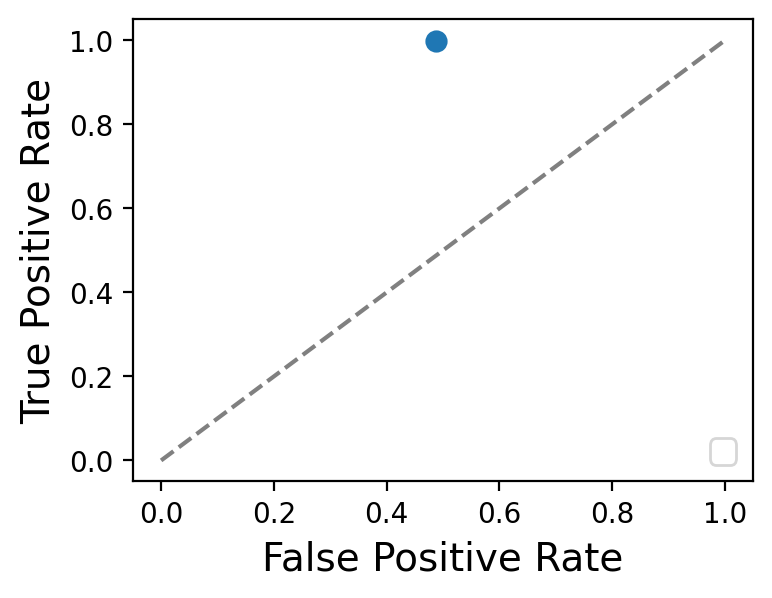

In [9]:
plt.figure(figsize=(4, 3), dpi=200)  # Smaller figure with high DPI for clarity

for i in [5, 10, 15, 20, 25, 30]:
    output_file = f'{output_dir}/{ATTACK}-{DATASET}-{GENERATOR}-gpt4-{RETRIEVER}-R3-Top{i}-M1000-N30.json'
    # If file does not exist, skip
    if not os.path.exists(output_file):
        continue
    with open(output_file, 'r') as f:
        data = json.load(f)

    # Assuming get_mia_scores is a function that extracts the relevant scores
    if ATTACK == 'mia':
        all_acc = get_mia_scores(data)
    elif ATTACK == 's2':
        all_acc = get_s2_scores(data)
    elif ATTACK == 'mba':
        all_acc = get_mba_scores(data)
    elif ATTACK == 'direct_query':
        accuracy, precision, recall, f1, fpr, tpr = get_dq_scores(data)
        print("Accuracy: {:.2f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, FPR: {:.4f}, TPR: {:.4f}".format(accuracy, precision, recall, f1, fpr, tpr))
        plt.scatter([fpr], [tpr], lw=2)
        break
    else:
        print('Invalid attack type')
        break
    mem_acc = all_acc[:len(all_acc)//2]
    nonmem_acc = all_acc[len(all_acc)//2:]

    # Generate labels: 1 for members, 0 for non-members
    labels = np.concatenate([np.ones(len(mem_acc)), np.zeros(len(nonmem_acc))])
    scores = np.concatenate([mem_acc, nonmem_acc])

    # Calculate FPR, TPR, and AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    # Compute accuracy for each threshold
    accuracies = {}
    for j, threshold in enumerate(thresholds):
        if threshold == np.inf:
            continue
        predicted_labels = (scores >= threshold).astype(int)
        accuracy = (predicted_labels == labels).mean()
        # See what FPR this threshold corresponds to
        fpr_corresponding = fpr[j]
        accuracies[int(i * threshold / 100)] = float(accuracy), float(fpr_corresponding)
    
    # Find threshold that yields FPR of FPR_FOR_AUC or less
    threshold_for_auc = thresholds[np.where(fpr <= FPR_FOR_AUC)[0][-1]]
    predicted_labels = (scores >= threshold_for_auc).astype(int)
    accuracy = (predicted_labels == labels).mean()

    # Calculate TPR at specific FPR thresholds using np.interp
    tpr_5_fpr = find_tpr_at_fpr(fpr, tpr, 0.05)
    tpr_1_fpr = find_tpr_at_fpr(fpr, tpr, 0.01)
    tpr_0_1_fpr = find_tpr_at_fpr(fpr, tpr, 0.001)

    # Print TPR values at the specified FPR thresholds
    print(f'Top-{i}: AUC = {roc_auc:.4f} | Accuracy =  {accuracy:.4f} | TPR@5% FPR = {tpr_5_fpr:.4f} | TPR@1%FPR = {tpr_1_fpr:.4f}, TPR@0.1%FPR = {tpr_0_1_fpr:.4f}')

    # Plot ROC curve for the current 'top'
    plt.plot(fpr, tpr, lw=2, label=f'{i} (AUC = {roc_auc:.4f})')

    # for i in range(len(fpr)):
        # print(f'FPR: {fpr[i]:.4f}, TPR: {tpr[i]:.4f}')
    # Print accuracies
    """
    for k, v in accuracies.items():
        print(f'Threshold: {k} with FPR {v[1]: .3f}, Accuracy: {v[0]:.3f}')
    print()
    """

# Add plot details
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
# Add log-log scaling if specified
if log_scale:
    plt.semilogx()
    plt.semilogy()
    plt.xlim(1e-3, 1)
    plt.ylim(1e-3, 1)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()


## Retrieval rate

In [10]:
# Process files for each k-value

k_values = [5, 10, 15, 20, 25, 30]
exact_counts = {}
for top_k in k_values:
    file_path = f'{output_dir}/{ATTACK}-{DATASET}-{GENERATOR}-gpt4-{RETRIEVER}-R3-Top{top_k}-M1000-N30.json'
    if not os.path.exists(file_path):
        continue
    exact_count_dict, retriever_recall = process_file(file_path)
    exact_counts[top_k] = exact_count_dict
    print("Recall for {}: {:.3f}".format(top_k, retriever_recall))

Recall for 30: 0.998
